In [1]:
import pickle
import os
import copy
from collections import defaultdict
import torch
import numpy as np
import random
from torchvision import datasets, transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = torch.nn.Linear(input_size, hidden_size, bias=False)
        #self.h2h = torch.nn.Linear(hidden_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, output_size, bias=False)
        
        self.logsoftmax = torch.nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.i2h(x))
        #x = F.relu(self.h2h(x))
        x = self.logsoftmax(self.h2o(x))
        return x

In [3]:
def train(model, criterion, optimizer, x, y):
    x = Variable(x.flatten(2,3), requires_grad=False)
    y = Variable(y, requires_grad=False)
    
    x = x.to(device)
    y = y.to(device)
    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    
    y_pred = torch.zeros((16,10))
    y_pred[:, :] = fx[:, 0, :]
    y_pred = y_pred.to(device)
    loss = criterion(y_pred, y)
    
    # Backward
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.item()

def predict(model, x, y):
    x = Variable(x.flatten(2,3), requires_grad=False)  
    x = x.to(device)
    outputs = model(x)
    outputs = outputs.to(device)
    _, predicted = torch.max(outputs.data, 2) #for each output, get the predicted value (torch.max returns (index, value) tuple)
    predicted = predicted.view(16)
    predicted = predicted.to(device)
    y = y.to(device)
    correct = (predicted == y) #how many predicted values equal the labels
    return correct.sum().item() 

def accuracy(pruned_model, test_dl, s):
    correct = 0
    pruned_model = pruned_model.to(device)
    for teX, teY in test_dl:
        teX = teX.to(device)
        teY= teY.to(device)
        correct += predict(pruned_model, teX, teY)
        
    return 100*correct/(16*len(test_dl))

In [4]:
from torch.autograd import Variable
import torch.nn.functional as F
def get_mnist(
        batch_size=16, binarize=False, download=True, downsample_params=None, net=Net(784, 10000, 10), epochs = 50, learning_rate = 3e-4, momentum = 0.9):
    trn_kwargs = {
        'batch_size': batch_size,
        'num_workers': 0,
        'shuffle': True,
    }
    test_kwargs = {
        'batch_size': batch_size,
        'num_workers': 0,
        'shuffle': False,
    }
    transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize((0.1307,), (0.3081,)),
            ])
    trn_ds = datasets.MNIST(
            root='./data', train=True, download=download, transform=transform)
    test_ds = datasets.MNIST(
            root='./data', train=False, download=download, transform=transform)
    
    trn_dl = torch.utils.data.DataLoader(trn_ds , **trn_kwargs)

    # test dataset is never modified during downsampling
    test_dl = torch.utils.data.DataLoader(test_ds, **test_kwargs)
    
    #return trn_ds, trn_ds.targets, test_ds, test_ds.targets
    
    
#     epochs = 50
#     learning_rate = 3e-4
#     momentum = 0.9
    
#     net = Net(784, 10000, 10)
    net = net.to(device)
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    
#     plot_loss = []
#     plot_correct = []
    acc = []
    for e in range(1, epochs+1):
        loss = 0.
        correct = 0.
        for trX, trY in trn_dl:
            loss += train(net, criterion, optimizer, trX, trY)
        for teX, teY in test_dl:
            correct += predict(net, teX, teY)
#         plot_loss.append(loss/len(trn_dl))
#         plot_correct.append(100*correct/(len(test_dl)*batch_size))
        print("Epoch %02d, loss = %f, accuracy = %.2f%%" % (e, loss / (len(trn_dl)), 100*correct/(len(test_dl)*batch_size)))
        acc.append(100*correct/(16*len(test_dl)))
    return net, trn_ds.data.flatten(1,2), trn_ds.targets, test_dl, acc


In [5]:
class Loss(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
    def forward(self, x, target):
        return 0.5*torch.sum((target - x)**2)

In [6]:
def gradDescent(model, full_pruned_weights_model, threek_pruned_model, indexer, data):
    
    loss = Loss()
    optimizer = torch.optim.Adam(full_pruned_weights_model.parameters(), lr=1e-8)
    
    for _ in range(50):
        optimizer.zero_grad()

        pruned_model_output = threek_pruned_model(data)
        og_model_output = model(data)
        
        train_loss = loss(pruned_model_output, og_model_output)     
        #print(train_loss)
        
        train_loss.backward()
        optimizer.step()
    
    full_pruned_weights_model.i2h.weight.data[indexer, :] = threek_pruned_model.i2h.weight.data[:indexer.shape[0],:] 
    full_pruned_weights_model.h2o.weight.data[:, indexer] = threek_pruned_model.h2o.weight.data[:, :indexer.shape[0]]
    
    return threek_pruned_model

In [7]:
def cs_prune_layer(model, X_train, results, num_neurons=100, total_iter=10):
    """prunes a two-layer neural network to a fixed number of neurons using
    CoSAMP algorithm -- any number of output neurons can be present"""

    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    assert model.hidden_size > num_neurons, "Error: pruned size is larger than dense size."
    X_train = X_train.to(device)

    model = model.to(device)
    
    k_pruned_model = Net(input_size=model.input_size, hidden_size=num_neurons, output_size=model.output_size)
    k_pruned_model = k_pruned_model.to(device)
    
    k_pruned_model.i2h.weight.data.fill_(0.00)
    k_pruned_model.h2o.weight.data.fill_(0.00)
    
    threek_pruned_model = Net(input_size=model.input_size, hidden_size=3*num_neurons, output_size=model.output_size)
    threek_pruned_model = threek_pruned_model.to(device)
    
    threek_pruned_model.i2h.weight.data.fill_(0.00)
    threek_pruned_model.h2o.weight.data.fill_(0.00)
    
    full_pruned_weights_model = Net(input_size=model.input_size, hidden_size=model.hidden_size, output_size=model.output_size)
    full_pruned_weights_model = full_pruned_weights_model.to(device)
    
    full_pruned_weights_model.i2h.weight.data = copy.deepcopy(model.i2h.weight.data.cpu())
    full_pruned_weights_model.h2o.weight.data = copy.deepcopy(model.h2o.weight.data.cpu())
  
    k_sparse_indices = set([])
    residual = None
    og_model_hidden = None
    og_model_output = None
    #eps = 1e-5 # stopping criterion for cosamp iterations
    iteration = 0

    while iteration < total_iter:
        # initial residual is just the model output
        if residual is None:
            with torch.no_grad():
                #what does hidden represent in single layer model?
                og_model_hidden = torch.sum(model.i2h.weight.data, dim=0).squeeze()
                print(model)
                print(X_train)
                og_model_output = model(X_train)
                residual = copy.deepcopy(og_model_output.cpu())
                residual = residual.to(device)
        
        # perform a cosamp iteration
        with torch.no_grad():
            # take max on residual after multiplication so negative weight/act combos are not negated
            hid_weight = model.h2o.weight.data
            importance = torch.mm(residual, hid_weight) # B x m (i.e., hid neuron importance over entire batch)
            importance = torch.sum(importance, dim=0).squeeze() # NOTE: may not be the best choice...
            imp_idxs = torch.argsort(importance, descending=True)[:2*num_neurons]
            tmp_imp_neurons = set(imp_idxs.cpu().tolist())
            bigger_neuron_set = tmp_imp_neurons.union(k_sparse_indices)
            indexer = torch.LongTensor(sorted(list(bigger_neuron_set))).to(device)
            
            #first projection to 3k model
            threek_pruned_model.i2h.weight.data[:indexer.shape[0],:] = copy.deepcopy(model.i2h.weight.data[indexer, :])
            threek_pruned_model.h2o.weight.data[:, :indexer.shape[0]] = copy.deepcopy(model.h2o.weight.data[:, indexer])
        
        
        with torch.no_grad():
            #old_k = copy.deepcopy(k_sparse_indices)
            hidden_sizes = torch.sum(threek_pruned_model.h2o.weight.data, dim=0).squeeze()#og_model_hidden[indexer]
            k_sparse_indices = torch.argsort(hidden_sizes, descending=True)[:num_neurons]
            k_sparse_indices = set(k_sparse_indices.cpu().tolist())
            k_indexer = torch.LongTensor(list(k_sparse_indices)).to(device)
            k_pruned_model.i2h.weight.data = threek_pruned_model.i2h.weight.data[k_indexer, :]
            k_pruned_model.h2o.weight.data = threek_pruned_model.h2o.weight.data[:, k_indexer]

        # compute the new residual
        with torch.no_grad():
            pruned_model_output = k_pruned_model(X_train)
            residual = og_model_output - pruned_model_output
        iteration += 1
        frob = float(torch.sum(residual**2)*(10**-7))
        exp_str = f'{num_neurons}_{"baseline"}'
        results[exp_str].append(frob)
    return k_pruned_model, k_sparse_indices


In [8]:
def cs_prune_layer_grad(model, X_train, results, num_neurons=100, total_iter=10):
    """prunes a two-layer neural network to a fixed number of neurons using
    CoSAMP algorithm -- any number of output neurons can be present"""

    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    assert model.hidden_size > num_neurons, "Error: pruned size is larger than dense size."
    X_train = X_train.to(device)

    model = model.to(device)
    
    k_pruned_model = Net(input_size=model.input_size, hidden_size=num_neurons, output_size=model.output_size)
    k_pruned_model = k_pruned_model.to(device)
    
    k_pruned_model.i2h.weight.data.fill_(0.00)
    k_pruned_model.h2o.weight.data.fill_(0.00)
    
    threek_pruned_model = Net(input_size=model.input_size, hidden_size=3*num_neurons, output_size=model.output_size)
    threek_pruned_model = threek_pruned_model.to(device)
    
    threek_pruned_model.i2h.weight.data.fill_(0.00)
    threek_pruned_model.h2o.weight.data.fill_(0.00)
    
    full_pruned_weights_model = Net(input_size=model.input_size, hidden_size=model.hidden_size, output_size=model.output_size)
    full_pruned_weights_model = full_pruned_weights_model.to(device)
    
    full_pruned_weights_model.i2h.weight.data = copy.deepcopy(model.i2h.weight.data)
    full_pruned_weights_model.h2o.weight.data = copy.deepcopy(model.h2o.weight.data)
  
    k_sparse_indices = set([])
    residual = None
    og_model_hidden = None
    og_model_output = None
    #eps = 1e-5 # stopping criterion for cosamp iterations
    iteration = 0

    while iteration < total_iter:
        # initial residual is just the model output
        if residual is None:
            with torch.no_grad():
                #what does hidden represent in single layer model?
                og_model_hidden = torch.sum(model.i2h.weight.data, dim=0).squeeze()
                og_model_output = model(X_train)
                residual = copy.deepcopy(og_model_output.cpu())
                residual = residual.to(device)
        
        # perform a cosamp iteration
        with torch.no_grad():
            # take max on residual after multiplication so negative weight/act combos are not negated
            hid_weight = full_pruned_weights_model.h2o.weight.data # n x m (i.e., dims are switched)
            importance = torch.mm(residual, hid_weight) # B x m (i.e., hid neuron importance over entire batch)
            importance = torch.sum(importance, dim=0).squeeze() # NOTE: may not be the best choice...
            imp_idxs = torch.argsort(importance, descending=True)[:2*num_neurons]
            tmp_imp_neurons = set(imp_idxs.cpu().tolist())
            bigger_neuron_set = tmp_imp_neurons.union(k_sparse_indices)
            indexer = torch.LongTensor(sorted(list(bigger_neuron_set))).to(device)
            
            #first projection to 3k model
            
            threek_pruned_model.i2h.weight.data[:indexer.shape[0],:] = full_pruned_weights_model.i2h.weight.data[indexer, :]
            threek_pruned_model.h2o.weight.data[:, :indexer.shape[0]] = full_pruned_weights_model.h2o.weight.data[:, indexer]
          
        #print("iteration: ", iteration)
        ## update weights here ## Step 3 of algorithm
        threek_pruned_model = gradDescent(model, full_pruned_weights_model, threek_pruned_model, indexer, X_train)
        
        with torch.no_grad():
            #old_k = copy.deepcopy(k_sparse_indices)
            hidden_sizes = torch.sum(threek_pruned_model.h2o.weight.data, dim=0).squeeze()#og_model_hidden[indexer]
            k_sparse_indices = torch.argsort(hidden_sizes, descending=True)[:num_neurons]
            k_sparse_indices = set(k_sparse_indices.cpu().tolist())
            k_indexer = torch.LongTensor(list(k_sparse_indices)).to(device)
            k_pruned_model.i2h.weight.data = threek_pruned_model.i2h.weight.data[k_indexer, :]
            k_pruned_model.h2o.weight.data = threek_pruned_model.h2o.weight.data[:, k_indexer]

        # compute the new residual
        with torch.no_grad():
            pruned_model_output = k_pruned_model(X_train)
            residual = og_model_output - pruned_model_output
        iteration += 1
        frob = float(torch.sum(residual**2)*(10**-7))
        exp_str = f'{num_neurons}_{"gradDescent"}'
        results[exp_str].append(frob)
    return k_pruned_model, k_sparse_indices


In [9]:
# dense_model, X_train, y_train, test_dl, d_acc = get_mnist(learning_rate=1e-8, epochs=30)
# X_train = X_train/255
# torch.save(dense_model, "dense_model")
model_path = "/kaggle/input/mnist-saved-model/dense_model"
dense_model, X_train, y_train, test_dl, d_acc = get_mnist(epochs=0)
X_train = X_train/255


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
results = defaultdict(list)
gd_results = defaultdict(list)

In [11]:
dense_model

Net(
  (i2h): Linear(in_features=784, out_features=10000, bias=False)
  (h2o): Linear(in_features=10000, out_features=10, bias=False)
  (logsoftmax): LogSoftmax(dim=None)
)

In [12]:
iterations = 20
# s_list=[100, 200, 300]
s_list = [100, 250, 500, 750, 1000, 1250]
acc = []
dense_model = torch.load(model_path)
for s in s_list:
    pruned_model, indexer = cs_prune_layer(dense_model, X_train, results, s, iterations)
    acc.append(accuracy(pruned_model, test_dl, s))
    torch.save(pruned_model, f"pruned_model_{s}")
#     new_model, X_train, y_train, test_dl = get_mnist(net=pruned_model)
#     acc.append(accuracy(pruned_model, test_dl, s))
    

Net(
  (i2h): Linear(in_features=784, out_features=10000, bias=False)
  (h2o): Linear(in_features=10000, out_features=10, bias=False)
  (logsoftmax): LogSoftmax(dim=None)
)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Net(
  (i2h): Linear(in_features=784, out_features=10000, bias=False)
  (h2o): Linear(in_features=10000, out_features=10, bias=False)
  (logsoftmax): LogSoftmax(dim=None)
)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
Net(
  (i2h): Linear(in_features=784, out_features=10000, bias=False)
  (h2o): Linear(in_features=10000, out_features=10, bias=False)
  (logsoftmax): LogSoftmax(dim=None)
)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
Net(
  (i2h): Linear(in_features=784, out_features=10000, bias=False)
  (h2o): Linear(in_features=10000, out_fea

In [13]:
iterations = 20
s_list = [100, 250, 500, 750, 1000, 1250]

acc = []
dense_model = torch.load(model_path)
for s in s_list:
    pruned_model, indexer = cs_prune_layer_grad(dense_model, X_train, gd_results, s, iterations)
    acc.append(accuracy(pruned_model, test_dl, s))
    torch.save(pruned_model, f"pruned_model_gd_{s}")
#     new_model, X_train, y_train, test_dl = get_mnist(net=pruned_model)
#     acc.append(accuracy(pruned_model, test_dl, s))
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [14]:
new_acc = []
labels = []
for s in s_list:
    pruned_model = torch.load(f"pruned_model_{s}")
    new_model, X_train, y_train, test_dl, acc = get_mnist(net=pruned_model)
    labels.append(f"pruned_model_{s}")
    new_acc.append(acc)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 01, loss = 1.744454, accuracy = 83.25%
Epoch 02, loss = 1.321352, accuracy = 84.85%
Epoch 03, loss = 1.244507, accuracy = 85.49%
Epoch 04, loss = 1.199551, accuracy = 86.26%
Epoch 05, loss = 1.168870, accuracy = 86.96%
Epoch 06, loss = 1.143171, accuracy = 87.35%
Epoch 07, loss = 1.122997, accuracy = 87.73%
Epoch 08, loss = 1.102883, accuracy = 88.03%
Epoch 09, loss = 1.086728, accuracy = 88.26%
Epoch 10, loss = 1.070491, accuracy = 88.46%
Epoch 11, loss = 1.064762, accuracy = 88.68%
Epoch 12, loss = 1.045397, accuracy = 88.74%
Epoch 13, loss = 1.042820, accuracy = 89.01%
Epoch 14, loss = 1.033053, accuracy = 89.15%
Epoch 15, loss = 1.023848, accuracy = 89.35%
Epoch 16, loss = 1.019028, accuracy = 89.42%
Epoch 17, loss = 1.011465, accuracy = 89.38%
Epoch 18, loss = 1.005813, accuracy = 89.47%
Epoch 19, loss = 1.004946, accuracy = 89.63%
Epoch 20, loss = 0.996745, accuracy = 89.68%
Epoch 21, loss = 0.990732, accuracy = 89.70%
Epoch 22, loss = 0.987947, accuracy = 89.72%
Epoch 23, 

In [15]:
# new_acc = []
for s in s_list:
    pruned_model = torch.load(f"pruned_model_gd_{s}")
    new_model, X_train, y_train, test_dl, acc = get_mnist(net=pruned_model)
    labels.append(f"pruned_model_gd_{s}")
    new_acc.append(acc)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 01, loss = 1.745442, accuracy = 83.30%
Epoch 02, loss = 1.315675, accuracy = 84.87%
Epoch 03, loss = 1.240824, accuracy = 85.52%
Epoch 04, loss = 1.195767, accuracy = 86.27%
Epoch 05, loss = 1.169209, accuracy = 87.05%
Epoch 06, loss = 1.139607, accuracy = 87.41%
Epoch 07, loss = 1.119403, accuracy = 87.77%
Epoch 08, loss = 1.098118, accuracy = 88.13%
Epoch 09, loss = 1.086265, accuracy = 88.39%
Epoch 10, loss = 1.068927, accuracy = 88.52%
Epoch 11, loss = 1.062177, accuracy = 88.62%
Epoch 12, loss = 1.051006, accuracy = 88.88%
Epoch 13, loss = 1.037872, accuracy = 89.10%
Epoch 14, loss = 1.030145, accuracy = 89.15%
Epoch 15, loss = 1.023979, accuracy = 89.25%
Epoch 16, loss = 1.019863, accuracy = 89.48%
Epoch 17, loss = 1.009063, accuracy = 89.51%
Epoch 18, loss = 1.004958, accuracy = 89.59%
Epoch 19, loss = 1.004104, accuracy = 89.61%
Epoch 20, loss = 0.998024, accuracy = 89.59%
Epoch 21, loss = 0.993000, accuracy = 89.68%
Epoch 22, loss = 0.988840, accuracy = 89.88%
Epoch 23, 

In [16]:
results

defaultdict(list,
            {'100_baseline': [4.446534633636475,
              4.414834976196289,
              4.375205039978027,
              4.381335735321045,
              4.381577014923096,
              4.382051944732666,
              4.381716251373291,
              4.381716251373291,
              4.38163423538208,
              4.38163423538208,
              4.381716251373291,
              4.381716251373291,
              4.38163423538208,
              4.38163423538208,
              4.381716251373291,
              4.381716251373291,
              4.38163423538208,
              4.38163423538208,
              4.381716251373291,
              4.381716251373291],
             '250_baseline': [4.446534633636475,
              4.376735210418701,
              4.348941802978516,
              4.330728054046631,
              4.334281921386719,
              4.332293510437012,
              4.332873821258545,
              4.323441028594971,
              4.331121444702148

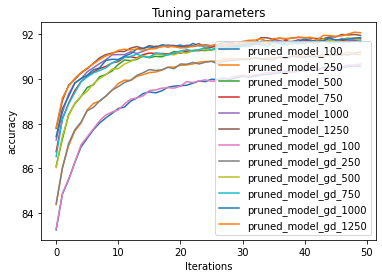

In [17]:
import matplotlib.pyplot as plt

for x, y in zip(new_acc, labels):
    plt.plot(x, label=y)

    
# plt.axhline(y=d_acc, color='r', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('accuracy')
plt.title('Tuning parameters')
# plt.ylim(70,100)
# plt.yscale('log')
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [18]:
labels

['pruned_model_100',
 'pruned_model_250',
 'pruned_model_500',
 'pruned_model_750',
 'pruned_model_1000',
 'pruned_model_1250',
 'pruned_model_gd_100',
 'pruned_model_gd_250',
 'pruned_model_gd_500',
 'pruned_model_gd_750',
 'pruned_model_gd_1000',
 'pruned_model_gd_1250']

In [19]:
[a[-1] for a in new_acc]

[90.57,
 91.1,
 91.76,
 91.66,
 91.82,
 91.95,
 90.67,
 91.21,
 91.75,
 91.7,
 91.85,
 92.07]

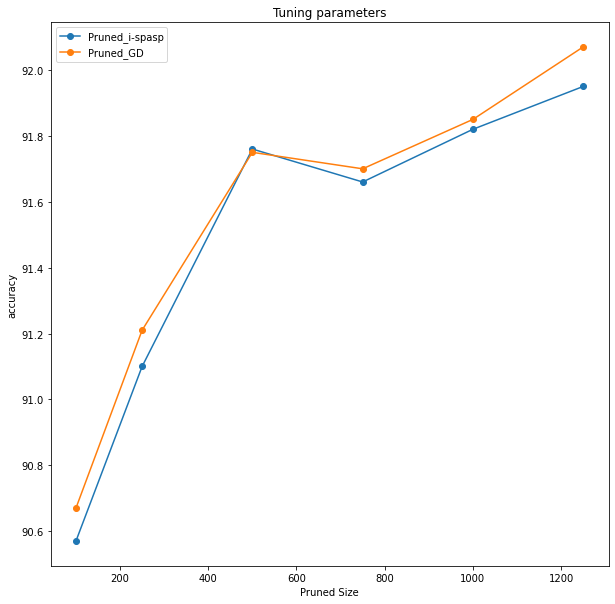

In [20]:
plt.plot(s_list, [a[-1] for a in new_acc[:len(s_list)]], label="Pruned_i-spasp", marker="o")
plt.plot(s_list, [a[-1] for a in new_acc[len(s_list):]], label="Pruned_GD", marker="o")

# plt.axhline(y=d_acc[-1], color='r', linestyle='-')
plt.xlabel('Pruned Size')
plt.ylabel('accuracy')
plt.title('Tuning parameters')
# plt.ylim(70,100)
# plt.yscale('log')
plt.legend()
plt.rcParams["figure.figsize"] = (10,10)
plt.show() 

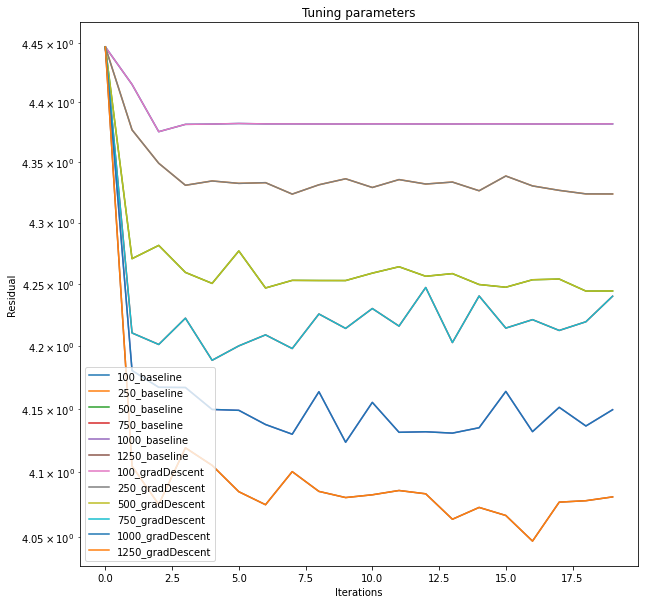

In [21]:
import matplotlib.pyplot as plt

for key in results.keys():
    plt.plot(results[key], label = key)
for key in gd_results.keys():
    plt.plot(gd_results[key], label = key)

plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.title('Tuning parameters')
plt.yscale('log')
plt.legend()
plt.rcParams["figure.figsize"] = (15,10)
plt.show()